# Testing the relationship between COTS outbreaks and post-cyclone salinity plumes

***Group 1, ENVI5809, Semester 2 2022***

*Beatriz Boggiani, Md. Yousef Gazi, Lachlan Perris, Jonathon Leonard*

*Note this code has been adapted from tutorials provided by Tristan Salles and the Ocean Parcels Development Team*

This notebook is to accompany the report and presentation for the ENVI5809 project. In this notebook we demonstrate how we use manta-tow survey data and eReefs modelling to derive and plot information on the relationship between COTS outbreaks and low-salinity plumes. 

Before starting, let's import any required libraries.

In [1]:
import sys, os, random, itertools
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4 as nc

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.shapereader as shpreader
cartopy.config['data_dir'] = os.getenv('CARTOPY_DIR', cartopy.config.get('data_dir'))

import cmocean
import imageio

from parcels import FieldSet, Field, ParticleSet, Variable, JITParticle
from parcels import AdvectionRK4, plotTrajectoriesFile, ErrorCode

import math
import datetime as dtime
from datetime import datetime
from datetime import timedelta
from operator import attrgetter

import matplotlib as mpl
from matplotlib import pyplot as plt
plt.ion()  # To trigger the interactive inline mode
plt.style.use("seaborn")

plt.rcParams['figure.figsize'] = (20,15) # Change default figure size
plt.rcParams.update({'axes.titlesize':16})
plt.rcParams.update({'axes.labelsize':16})

C:\Users\lachl\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\lachl\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\lachl\anaconda3\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\lachl\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


We also define a few handy variables

In [2]:
data_name ='ereefdata.nc' # The name of the combined .nc grid of all the months of salinity data combined

# The coordinates of some North Queensland towns (for plotting)
cairnsLat, cairnsLon = -16.92, 145.77
rockhamptonLat, rockhamptonLon = -23.38, 150.51
bowenLat, bowenLon = -20.01, 148.25

Also some plotting functions to make things easy and consistent

In [3]:
def plot_town(townname='cairns'):
    lat = f'{townname}Lat'
    lon = f'{townname}Lon'
    plt.plot(globals()[lon], globals()[lat], color='red', marker='s', linewidth=2, mew=0.1, mec='black', transform=ccrs.PlateCarree())
    plt.text(globals()[lon]-0.2, globals()[lat]-0.1, f'{townname.capitalize()}', horizontalalignment='right', transform=ccrs.PlateCarree())

Initialise output directories

In [4]:
# Parcels output
parcels_directory = 'parcels_output'
os.makedirs(parcels_directory, exist_ok=True)

# Parcels images
parcels_figs = 'parcels_figs'
os.makedirs(parcels_figs, exist_ok=True)

## Locate COTS outbreaks

First we use manta-tow data from the Australian Institute of Marine Science to locate where and when COTS outbreaks were recorded.

In [5]:
data = 'datasets/manta-tow-by-reef/manta-tow-by-reef.csv' # path to manta-tow data saved locally
df = pd.read_csv(data) # Read the manta-tow data into pandas

# Drop unneeded columns
df = df.drop(columns=['SECTOR','SHELF','REEF_ID','P_CODE','VISIT_NO', 'REPORT_YEAR','MEDIAN_LIVE_CORAL','MEDIAN_SOFT_CORAL', 'MEDIAN_DEAD_CORAL',
       'MEAN_LIVE_CORAL', 'MEAN_SOFT_CORAL', 'MEAN_DEAD_CORAL', 'TOTAL_TROUT', 'MEAN_TROUT_PER_TOW', 'TOWS'])

# Convert date column to datetime
df['SAMPLE_DATE'] = pd.to_datetime(df['SAMPLE_DATE']) 

# Add year and month columns for easier processing later on
df['YEAR'] = df['SAMPLE_DATE'].dt.year
df['MONTH'] = df['SAMPLE_DATE'].dt.month

df.head(2) # Check the data has loaded correctly

,REEF_NAME,LATITUDE,LONGITUDE,YEAR_CODE,SAMPLE_DATE,TOTAL_COTS,MEAN_COTS_PER_TOW,YEAR,MONTH
0,LOW ISLANDS REEF,-16.383333,145.566667,199293,1993-06-11,0,0.0,1993,6
1,LOW ISLANDS REEF,-16.383333,145.566667,199596,1996-01-15,0,0.0,1996,1


Now we can plot all our data to get a rough idea of some of the patterns and how it looks. The below graph shows that COTS outbreaks are seasonal, with most appearing at the beginning of the year. We can also see clusters of very high outbreaks around the year 2000 and 2018.

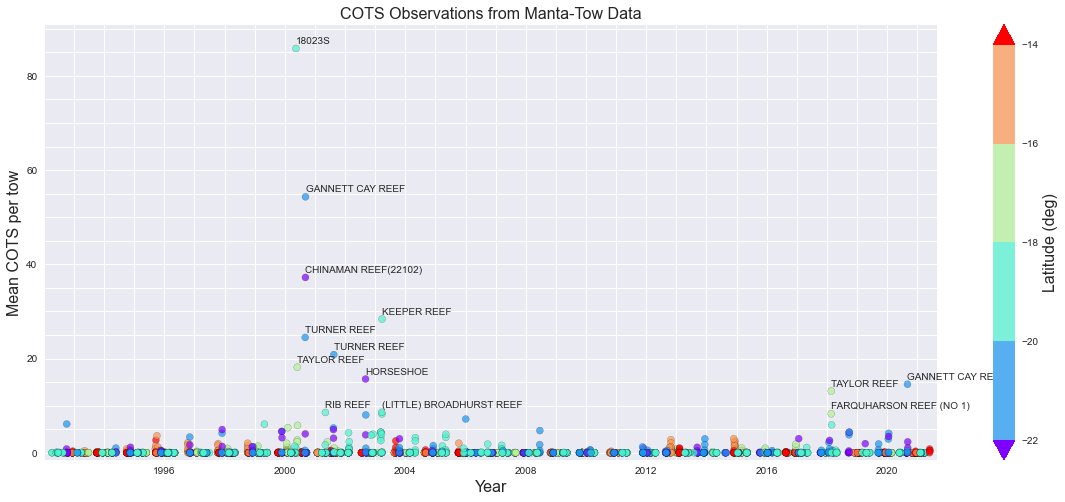

In [6]:
# Set up our colour palette and boundaries
cmap = plt.cm.rainbow # Use rainbow to easily distinguish between discrete colour bins
norm = mpl.colors.BoundaryNorm(np.arange(-22, -12, 2), cmap.N, extend='both') # Set the boundaries of the discrete colour paletter

# Plot the mean-cots-per-tow against date, coloured by the reef's latitude
fig = plt.figure(1, figsize=(20,8))
plt.scatter(df['SAMPLE_DATE'], df['MEAN_COTS_PER_TOW'], c=df['LATITUDE'], cmap=cmap, norm=norm, alpha=0.7, edgecolors='black', linewidth=0.2)

#Find and label the top N observations:
most_cots = df.sort_values("MEAN_COTS_PER_TOW", ascending = False).reset_index(drop=True).copy()
for k in range (13): #Change how many of labels appear on the plot
    plt.text(most_cots['SAMPLE_DATE'][k], most_cots['MEAN_COTS_PER_TOW'][k]+1,most_cots['REEF_NAME'][k])




plt.ylim(-1.5,max(df['MEAN_COTS_PER_TOW'])+5)
plt.xlim(min(df['SAMPLE_DATE'])-timedelta(days=90), max(df['SAMPLE_DATE'])+timedelta(days=90))
plt.minorticks_on()
plt.grid(which ='both', color='w')
plt.title("COTS Observations from Manta-Tow Data")
plt.xlabel('Year')
plt.ylabel('Mean COTS per tow')
cbar = plt.colorbar()
cbar.set_label('Latitude (deg)')

#plt.savefig('Plots_Final/COTS_distribution.png', dpi=300, bbox_inches="tight")

### Identify large COTS numbers

As a rough identification of large outbreaks, let's identify only outbreaks that are significantly larger than the mean value.

In [7]:
mean = df['MEAN_COTS_PER_TOW'].mean()
print(f"The average COTS per tow detected across the whole dataset is {round(mean,3)}")

# Let's work with all data that has recorded at least some COTS (so we can get closer to a normal distribution and using standard deviation makes a bit more sense)
df_nonzero = df[df['MEAN_COTS_PER_TOW'] > 0]
mean_nonzero = df_nonzero['MEAN_COTS_PER_TOW'].mean()
std_nonzero = df_nonzero['MEAN_COTS_PER_TOW'].std()

# Now add a new column to the original dataset that displays the standard deviation for non-zero Mean-COTS-per-tow data
df['DEVIATION'] = np.abs(df['MEAN_COTS_PER_TOW']/std_nonzero)

The average COTS per tow detected across the whole dataset is 0.295


### Plot COTS outbreaks

Now let's define a function that plots COTS outbreaks

In [8]:
def plot_outbreaks(x,y,z,w):
    """Plots the spatial and temporal extent of COTS outbreaks"""
    fig = plt.figure(facecolor='w', edgecolor='k')
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    cmap = cmocean.cm.thermal # Use rainbow to easily distinguish between discrete colour bins
    norm = mpl.colors.BoundaryNorm(np.arange(w.min(), w.max(),1), cmap.N, extend='both') # Set the boundaries of the discrete colour paletter
    
    # Add features from a shapefile, this shapefile is of reef features in the GBR
    ax.add_feature(cartopy.feature.ShapelyFeature(shpreader.Reader('datasets/Shapefiles/GBR_Features.shp').geometries(), 
                                                   ccrs.PlateCarree(), facecolor="lightgrey", edgecolor='black', lw=0.05))

    # Add map features from cartopy
    ax.coastlines(linewidth=1)
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', 
                                                edgecolor='face', 
                                                facecolor='lightgray'))
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m', 
                                                edgecolor='darkblue', 
                                                facecolor='none'))
    
    plot = plt.scatter(x, y, s=z*30, c=w, cmap=cmap, norm = norm, zorder=10, alpha=0.7)
    
    
    plt.title('Spatial and temporal extent of COTS observations')
    
    # produce a legend with a cross section of sizes from the scatter
    handles, labels = plot.legend_elements(prop="sizes", alpha=0.6,  func = lambda x: x/15)
    legend2 = ax.legend(handles, labels, loc="upper right", title="Number of observed COTS")
    
    # Add gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='grey', alpha=0.5, linestyle='-', draw_labels=True)
    gl.top_labels = False
    gl.left_labels = False
    gl.right_labels=True
    gl.xlines = True
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    # Plot towns
    plot_town(townname='cairns')
    plot_town(townname='rockhampton')
    plot_town(townname='bowen')
    
    # Color bar
    cbar = fig.colorbar(plot, ax=ax, fraction=0.027, pad=0.035, orientation='horizontal')
    
    plt.show()

Plot the outbreaks with a mean of more than one COTS sighting per tow

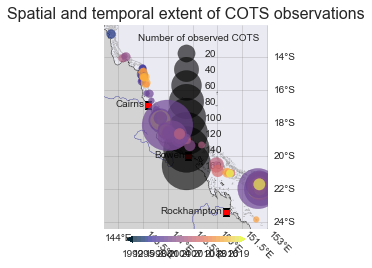

In [9]:
# The AIMS website shows high COTS number are when the mean per tow is > 1
highishCOTS = df[df['MEAN_COTS_PER_TOW'] > 1] 
highishCOTS = highishCOTS.reset_index() # reset the index for exporting 

x = highishCOTS["LONGITUDE"]
y = highishCOTS["LATITUDE"]
z = highishCOTS['MEAN_COTS_PER_TOW']
w = highishCOTS['YEAR']

plot_outbreaks(x,y,z,w)

Now let's look at only the most significant COTS outbreaks. We judged this as those outbreaks that were more than a standard deviation higher than the mean COT sighting. Note: we only calculated the standard deviation for where there were COTS sighted, i.e. values of zero COTS sighted were excluded.

                 REEF_NAME SAMPLE_DATE  MEAN_COTS_PER_TOW  DEVIATION
0  FARQUHARSON REEF (NO 1)  2018-02-21              8.269   1.802895
1              TAYLOR REEF  2018-02-22             13.102   2.856637
2         GANNETT CAY REEF  2020-09-03             14.542   3.170602
3                 RIB REEF  2018-02-26              5.909   1.288343


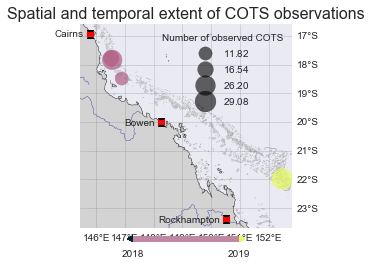

In [10]:
highCOTS = df[(df['DEVIATION'] > 1) & (df['YEAR'] >= 2010)] # Limit high COTS to years after 2010 as this is when eReefs data starts
highCOTS = highCOTS.reset_index(drop=True) # reset the index for exporting 

# Let's look at the data. For simplicity we only print some columns
print(highCOTS[['REEF_NAME', 'SAMPLE_DATE', 'MEAN_COTS_PER_TOW', 'DEVIATION']])

# Now plot the data
x = highCOTS["LONGITUDE"]
y = highCOTS["LATITUDE"]
z = highCOTS['MEAN_COTS_PER_TOW']
w = highCOTS['YEAR']

plot_outbreaks(x,y,z,w)

### Export to csv

Export our high COTS dataframe to a csv for resusing later

In [11]:
csv_filepath = 'datasets/highCOTS.csv'
if os.path.isfile(csv_filepath):
    os.remove(csv_filepath)
highCOTS.to_csv(csv_filepath, index=False)


# and export a table for the final report
highCOTS2 = highCOTS[['REEF_NAME', 'SAMPLE_DATE', 'MEAN_COTS_PER_TOW', 'DEVIATION']]
csv_filepath = 'datasets/highCOTS2.csv'
if os.path.isfile(csv_filepath):
    os.remove(csv_filepath)
highCOTS2.to_csv(csv_filepath, index=False)




## Use eReefs to find salinity and current data

Now that we have identified times and locations on COTS outbreaks, we can use eReefs to plot salinity levels and ocean currents around those times.

### eReefs Map Function

In [25]:
def ereefs_map(nc_data, tindex, depth, variable, size, figname='untitled', zoom=None, show=False, save=True):
    dir_name = f'{figname}_images'
    os.makedirs(dir_name, exist_ok=True) # Make directory to put the images in 
    
    #Set some parameters of the plot based on the variable selected:
    if variable == 'mean_cur':
        color = cmocean.cm.speed
        extent = [0,1]
    else:
        pass
    
    if variable =='salt':
        color = cmocean.cm.haline # Custom colour paletter for salinity
        extent = [26,35]
    else:
        pass 
    
    
    
    # data = nc_data[variable][tindex, depth, :,:] # produces an array
    data = nc_data[variable][tindex, :,:] # Currently have sliced grid to one depth level so taken depth out
    lat = nc_data['latitude'][:]
    lon = nc_data['longitude'][:]
    time = nc_data.variables['time']
    
    #Set up the plot:
    fig = plt.figure(figsize=size, facecolor='w', edgecolor='k')
    ax = plt.axes(projection=ccrs.PlateCarree())
    # ax.set_extent([np.min(lon), np.max(lon), np.max(lat), np.min(lat)], ccrs.PlateCarree())
    ax.set_extent([143, 153, -9.5, -25], ccrs.PlateCarree())
    
    plot = plt.pcolormesh(lon, lat, data, cmap=color, shading='auto', vmin=extent[0], vmax=extent[1], transform=ccrs.PlateCarree())
    
    #If plotting current we can include vectors:
    if variable == 'mean_cur':
        # Resampling using the slice method
        resample = ds_hydro_clip.isel(time=timevar, longitude=slice(None, None, 7),latitude=slice(None, None, 7))
        # Defining the quiver plot
        quiver = resample.plot.quiver(x='longitude', y='latitude', u='u', v='v', transform=ccrs.PlateCarree(), scale=8)  
        # Vector options declaration
        veclenght = 0.5
        maxstr = '%3.1f m/s' % veclenght
        plt.quiverkey(quiver,0.1,0.1,veclenght,maxstr,labelpos='S', 
                  coordinates='axes').set_zorder(11)
    else:
        pass  
    
    
    # Plot towns
    plot_town(townname='cairns')
    plot_town(townname='rockhampton')
    plot_town(townname='bowen')
    
    # Color bar
    cbar = fig.colorbar(plot, ax=ax, fraction=0.027, pad=0.035, orientation='horizontal')
    cbar.set_label(nc_data[variable].units, fontsize=12)
    cbar.ax.tick_params(labelsize=10)
    
    # Title
    dtime = nc.num2date(nc_data['time'][tindex],nc_data['time'].units)
    time_format = dtime.strftime('%b %d %Y %I%p')
    plt.title(f"{nc_data[variable].long_name} {time_format}", fontsize=14, pad=4)
    
    # Plot lat/lon grid
    gridlines = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.1, color='k', alpha=1, linestyle='--')
    gridlines.top_labels =  False
    gridlines.right_labels = False
    
    gridlines.xformatter = LONGITUDE_FORMATTER # from cartopy mpl gridliner class
    gridlines.yformatter = LATITUDE_FORMATTER
    
    gridlines.xlabel_style = {'size': 8}
    gridlines.ylabel_style = {'size': 8}
    
    ## Add GBR Shapefile
    ax.add_feature(cartopy.feature.ShapelyFeature(shpreader.Reader('datasets/Shapefiles/GBR_Features.shp').geometries(), 
                                                   ccrs.PlateCarree(), facecolor="lightgrey", edgecolor='black', lw=0.5))
    
    
    # Add map features from cartopy
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', 
                                                edgecolor='face', 
                                                facecolor='lightgray'))
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m', 
                                                edgecolor='darkblue', 
                                                facecolor='none'))
    ax.coastlines(linewidth=1)
    
    if zoom is not None:
        plt.xlim(zoom[0],zoom[2])
        plt.ylim(zoom[1],zoom[3])
         
    imname = f"{figname}_{dtime.strftime('%b_%d_%Y_%I%p')}_zc{depth:04}.png"
    impath = f'{dir_name}/{imname}'
    if os.path.isfile(impath):
        os.remove(impath)
    
    if show:
        if save:
            plt.savefig(impath,dpi=300, 
                    bbox_inches='tight')
            # images.append(imageio.imread(imname))
        plt.tight_layout()
        plt.show()
    else:
        plt.savefig(impath,dpi=300, 
                    bbox_inches='tight')
        # images.append(imageio.imread(imname))

    fig.clear()
    plt.close(fig)
    plt.clf()
    
    return impath

### Retrieving eReefs Data

In [13]:
# The stem of a url where ereefs data will be retrieved
base_url = "http://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/gbr4_v2/daily-monthly/EREEFS_AIMS-CSIRO_gbr4_v2_hydro_daily-monthly-"

# Choose the variable and depth to plot
variable = ['salt', 'mean_cur'] #We will take salinity and mean current data

# Depth does from deepest-shallowest, so -1 will be the shallowest layer (i.e. the surface) 
#   and -2 the second shallowest

depthIndex = [-1, -2] 

# Choose the time frame to plot
cots_months = [11,12,1,2] # The months where cots larvae breed
year_st = 2017 # Starting year (so Dec 2018 for example)

# Use indexing to get the month-year .nc files 
years = []
hydrofiles = [] # Empty list where the desired eReefs filenames will be appended
for m in range(len(cots_months)): 
    month = cots_months[m]
    if m == 0: # For the first month in our list, the year is the start year
        year = year_st
        years.append(year)
    elif cots_months[m] > cots_months[m-1]:
        year = years[m-1]
        years.append(year)
    else:
        year = year_st + 1
        years.append(year)
    
    hydrofile = f"{base_url}{year}-{month:02}.nc"
    hydrofiles.append(hydrofile)

ds_hydro = xr.open_mfdataset(hydrofiles)
ds_hydro

<xarray.Dataset>
Dimensions:      (time: 120, k: 17, latitude: 723, longitude: 491)
Coordinates:
    zc           (k) float64 dask.array<chunksize=(17,), meta=np.ndarray>
  * time         (time) datetime64[ns] 2017-10-31T14:00:00 ... 2018-02-27T14:...
  * latitude     (latitude) float64 -28.7 -28.67 -28.64 ... -7.096 -7.066 -7.036
  * longitude    (longitude) float64 142.2 142.2 142.2 ... 156.8 156.8 156.9
Dimensions without coordinates: k
Data variables:
    mean_cur     (time, k, latitude, longitude) float32 dask.array<chunksize=(30, 17, 723, 491), meta=np.ndarray>
    salt         (time, k, latitude, longitude) float32 dask.array<chunksize=(30, 17, 723, 491), meta=np.ndarray>
    temp         (time, k, latitude, longitude) float32 dask.array<chunksize=(30, 17, 723, 491), meta=np.ndarray>
    u            (time, k, latitude, longitude) float32 dask.array<chunksize=(30, 17, 723, 491), meta=np.ndarray>
    v            (time, k, latitude, longitude) float32 dask.array<chunksize=(30, 17, 723, 491), meta=np.ndarray>
    mean_wspeed  (time, latitude, longitude) float32 dask.array<chunksize=(30, 723, 491), meta=np.ndarray>
    eta          (time, latitude, longitude) float32 dask.array<chunksize=(30, 723, 491), meta=np.ndarray>
    wspeed_u     (time, latitude, longitude) float32 dask.array<chunksize=(30, 723, 491), meta=np.ndarray>
    wspeed_v     (time, latitude, longitude) float32 dask.array<chunksize=(30, 723, 491), meta=np.ndarray>
Attributes: (12/19)
    Conventions:                     CF-1.0
    Run_ID:                          2
    _CoordSysBuilder:                ucar.nc2.dataset.conv.CF1Convention
    aims_ncaggregate_buildDate:      2020-08-21T12:46:10+10:00
    aims_ncaggregate_datasetId:      products__ncaggregate__ereefs__gbr4_v2__...
    aims_ncaggregate_firstDate:      2017-11-01T00:00:00+10:00
    ...                              ...
    paramhead:                       GBR 4km resolution grid
    shoc_version:                    v1.1 rev(5620)
    technical_guide_link:            https://eatlas.org.au/pydio/public/aims-...
    technical_guide_publish_date:    2020-08-18
    title:                           eReefs AIMS-CSIRO GBR4 Hydrodynamic v2 d...
    DODS_EXTRA.Unlimited_Dimension:  time

The eReefs files are large, so we slide them to the areas we are mainly interested in

In [23]:
# Only plot data where high amounts of COTS are found. Here we use the manta-tow COTS data- all the occasions where mean-cot-per-tow was recorded
min_lon = df['LONGITUDE'].min() - 1     # lower left longitude
min_lat = df['LATITUDE'].min() - 1      # lower left latitude
max_lon = df['LONGITUDE'].max() + 1      # upper right longitude
max_lat = df['LATITUDE'].max() + 1      # upper right latitude

# Defining the boundaries
lon_bnds = [min_lon, max_lon]
lat_bnds = [min_lat, max_lat]

# # Slicing the grid and only taking surface (k=-1) and second layers (k=-2) (COTS Larvae are transported along the surface)
ds_hydro_clip = ds_hydro.sel(latitude=slice(*lat_bnds), longitude=slice(*lon_bnds), k=-1)
#ds_hydro_deep = ds_hydro.sel(latitude=slice(*lat_bnds), longitude=slice(*lon_bnds), k=-2)



#We need to load the different depths as different files.
#Since we are only loading two depths, this is the easiest way to cut the data size in half.
#We have called these files 'surf_data' and 'deeper_data'. 
# first we will look at currents:
#Drop the data that is not being used:
surf_data = ds_hydro_clip.drop(['zc','mean_wspeed','temp',
                    'eta','wspeed_u','wspeed_v', 'salt'])

#deep_data = ds_hydro_deep.drop(['zc','mean_wspeed','temp',
#                    'eta','wspeed_u','wspeed_v', 'salt'])

In [15]:
'''

## Then we can load the salinity data at two different depths:
# Slicing the grid and only taking surface and second layers (COTS Larvae are transported along the surface)
ds_hydro_shallow = ds_hydro.sel(latitude=slice(*lat_bnds), longitude=slice(*lon_bnds), k=-1)
ds_hydro_deep = ds_hydro.sel(latitude=slice(*lat_bnds), longitude=slice(*lon_bnds), k=-2)



#We need to load the different depths as different files.
#Since we are only loading two depths, this is the easiest way to cut the data size in half.
#We have called these files 'surf_data' and 'deeper_data'. 
# Now we can look at salinity:
#Drop the data that is not being used:
salt_surf_data = ds_hydro_shallow.drop(['zc','mean_wspeed','temp',
                    'eta','wspeed_u','wspeed_v', 'mean_cur'])

salt_deep_data = ds_hydro_deep.drop(['zc','mean_wspeed','temp',
                    'eta','wspeed_u','wspeed_v', 'mean_cur'])
                    
                    
'''

"\n\n## Then we can load the salinity data at two different depths:\n# Slicing the grid and only taking surface and second layers (COTS Larvae are transported along the surface)\nds_hydro_shallow = ds_hydro.sel(latitude=slice(*lat_bnds), longitude=slice(*lon_bnds), k=-1)\nds_hydro_deep = ds_hydro.sel(latitude=slice(*lat_bnds), longitude=slice(*lon_bnds), k=-2)\n\n\n\n#We need to load the different depths as different files.\n#Since we are only loading two depths, this is the easiest way to cut the data size in half.\n#We have called these files 'surf_data' and 'deeper_data'. \n# Now we can look at salinity:\n#Drop the data that is not being used:\nsalt_surf_data = ds_hydro_shallow.drop(['zc','mean_wspeed','temp',\n                    'eta','wspeed_u','wspeed_v', 'mean_cur'])\n\nsalt_deep_data = ds_hydro_deep.drop(['zc','mean_wspeed','temp',\n                    'eta','wspeed_u','wspeed_v', 'mean_cur'])\n                    \n                    \n"

### Selecting areas of low-salinity only

The below cell creates a new xarray dataset that contains the areas of low salinity only. We restricted it to salinities between 20 and 27 PSU. We chose to cut out data at ultra-low salinities to try minimise data very close to coastlines as this is unlikely to be where bipannaria spawn.

Note: this takes a long time to run

In [16]:
# low_sal = surf_data.where((surf_data['salt']<30) & (surf_data['salt']>20), drop=True).squeeze()

We save our combined and sliced dataset to a netCDF file. Note: the below cell takes ~3 minutes to run. Only re-run this when changing the times or bounds of the area you're looking at.

In [17]:
# Remove a previously saved netcdf file if needed
try:
    os.remove(data_name)
except OSError:
    pass
surf_data.to_netcdf(path=data_name)


KeyboardInterrupt: 

Plot the netcdf grids and create an animation of the change over time.

In [20]:
# Read in netCDF grid (created above)
ncdata = nc.Dataset('ereefdata.nc', 'r')
print('We have salinity data: ')
#print(ncdata.variables['salt'])
print('And we have mean current data: ')
print(ncdata.variables['mean_cur'])


We have salinity data: 
And we have mean current data: 
<class 'netCDF4._netCDF4.Variable'>
float32 mean_cur(time, latitude, longitude)
    _FillValue: nan
    substanceOrTaxon_id: http://environment.data.gov.au/def/feature/ocean_current
    units: ms-1
    medium_id: http://environment.data.gov.au/def/feature/ocean
    unit_id: http://qudt.org/vocab/unit#MeterPerSecond
    short_name: mean_cur
    aggregation: mean_speed
    standard_name: mean_current_speed
    long_name: mean_current_speed
    _ChunkSizes: [  1   1 133 491]
    coordinates: time zc latitude longitude
unlimited dimensions: 
current shape = (120, 546, 384)
filling on
And we have data for the second deepest layer:
We have salinity data: 


KeyError: 'salt'

Select the variables you would like to plot:

In [1]:
size = (9, 10) # Figsize
time = ncdata.variables['time']

# Create an empty list of images to append to:
images = []

#Select the variables you would like to plot:
variable = 'salt'
#variable = 'mean_cur'


# Time step to plot
timevar = 0


# Loop over each day and create a plot of the salinity
for t in range(4):
    im = ereefs_map(ncdata, t, depthIndex, variable, size, figname='salinity', show=True, save = False)
    #images.append(imageio.v2.imread(im)) # Append each image created to a list for conversion into animation

# Convert images to animation
#animation_name = f'{variable}_{str(year_st)}_{str(year_st+1)}_months_{cots_months[0]}_to_{cots_months[-1]}.gif'
#imageio.mimwrite(animation_name,images)

NameError: name 'ncdata' is not defined

In [ ]:
depthIndex = -1
for t in range(1):
    im = ereefs_map(ncdata, t, depthIndex, 'mean_cur', size, figname='Salinity', show=True, save = False)
depthIndex = -10
for t in range(1):
    im = ereefs_map(ncdata, t, depthIndex, 'mean_cur', size, figname='Salinity', show=True, save = False)

## Tracking with parcels

### Setting up parcels tracking

In [ ]:
# Define a function to delete particles that go out of bounds
def DeleteParticle(particle, fieldset, time):
     particle.delete()

In [ ]:
filenames = {'U': data_name,
             'V': data_name,
            }

In [ ]:
variables = {'U': 'u',
             'V': 'v',
            }

dimensions = {'lat': 'latitude',
              'lon': 'longitude',
              'time': 'time'}

In [ ]:
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)

In [ ]:
filenames = {'lat': data_name,
             'lon': data_name,
             'data': data_name}

variable = ('S', 'salt')

dimensions = {'lat': 'latitude',
              'lon': 'longitude',
              'time': 'time'}

field = Field.from_netcdf(filenames, variable, dimensions)
fieldset.add_field(field)

In [ ]:
class SampleParticle(JITParticle):          # Define a new particle class
    t = Variable('s', initial=fieldset.S)  # Variable 't' initialised by sampling the temperature

In [ ]:
def SampleS(particle, fieldset, time):  # Custom function that samples fieldset2.T at particle location
    particle.s = fieldset.S[time, particle.depth, particle.lat, particle.lon]

### Plotting Parcel Tracking

In [ ]:
df['LATITUDE'].max()

In [ ]:
def plot_parcels(output_nc, start_lons, start_lats, reef_names, variable='salinity',dt='backwards',start_date='unknown_start', end_date='unknown_end'):
    print('Plotting Parcels')
    
    parcels = xr.open_dataset(output_nc)
    
    # Figure size
    size = (10, 12)

    # Color from cmocean
    color = cmocean.cm.speed

    # Defining the figure
    fig = plt.figure(figsize=size, facecolor='w', edgecolor='k')

    # Axes with Cartopy projection
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # and extent
    # min_lon=df['LONGITUDE'].min()
    # max_lon=df['LONGITUDE'].max()
    # min_lat=df['LATITUDE'].min()
    # max_lat=df['LATITUDE'].max()
    
    min_lon=143
    max_lon=149
    min_lat=-20
    max_lat=-10
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], ccrs.PlateCarree())

    # Plotting using Matplotlib 
    # We plot the PH at the surface at the final recorded time interval
    cf = ds_hydro_clip.mean_cur.isel(time=10).plot( 
        transform=ccrs.PlateCarree(), cmap=color,
        vmin = 0.1, vmax = 1.0, alpha=0.2, 
        add_colorbar=False
    )

    # Color bar
    cbar = fig.colorbar(cf, ax=ax, fraction=0.027, pad=0.045, 
                        orientation="horizontal")
    cbar.set_label(ds_hydro_clip.mean_cur.long_name+' '+ds_hydro_clip.mean_cur.units, rotation=0, labelpad=5, fontsize=10)
    cbar.ax.tick_params(labelsize=8)

    # Title
    plt.title('Parcels evolution coloured by salinity',fontsize=13)

    # Plot lat/lon grid 
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0.1, color='k', alpha=1,linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8} 
    
    ## Add GBR Shapefile
    ax.add_feature(cartopy.feature.ShapelyFeature(shpreader.Reader('datasets/Shapefiles/GBR_Features.shp').geometries(), 
                                                   ccrs.PlateCarree(), facecolor="lightgrey", edgecolor='black', lw=0.5))

    # Add map features with Cartopy 
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', 
                                                edgecolor='face', 
                                                facecolor='lightgray'))
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m', 
                                                    edgecolor='darkblue', 
                                                    facecolor='none'))
    ax.coastlines(linewidth=1)

    distmin = 26.0
    distmax = parcels.s.max().item()

    mStyles = ["o","v","^","<",">","8","s","p","P","*","h","H","X","D","d"] # List of markerstykles to loop through
    m = itertools.cycle(mStyles)
    
    if dt == "forwards":
        divider=5
    elif dt == "backwards":
        divider=1
    
    for k in range(parcels.lon.shape[0]):
        mark = next(m)
        n = random.randint(1,divider) # Only plot 1 in 3 reefs to avoid cluttering the figure
        if (n % divider == 0):
            sc = plt.scatter(parcels.lon.isel(trajectory=k), parcels.lat.isel(trajectory=k), s=60, marker=mark, c=parcels.s.isel(trajectory=k), edgecolors='k',cmap=cmocean.cm.haline, vmin=distmin, vmax=distmax, linewidth=0.2, transform=ccrs.PlateCarree()).set_zorder(11)
            start_lon = parcels.lon.values[k][0]
            start_lat = parcels.lat.values[k][0]
            start_sal = parcels.s.values[k][0]
            plt.scatter(start_lon, start_lat, s=80, marker=mark, facecolor='none', edgecolors='black',cmap=cmocean.cm.haline, vmin=distmin, vmax=distmax, linewidth=1, transform=ccrs.PlateCarree(), zorder=12)
    
    # Color bar
    norm = mpl.colors.Normalize(vmin=distmin,vmax=distmax)
    sc = plt.cm.ScalarMappable(cmap=cmocean.cm.haline, norm=norm)
    
    cbar2 = plt.colorbar(sc, ax=ax, fraction=0.027, pad=0.045)
    cbar2.set_label('Surface salinity in PSU', rotation=90, labelpad=5, fontsize=10)
    cbar2.ax.tick_params(labelsize=8)

    # Plot towns
    plot_town(townname='cairns')
    plot_town(townname='rockhampton')
    plot_town(townname='bowen')

    # Annotating times
    date_st = parcels['time'][0].min(skipna=True).dt.strftime('%b %d %Y %I%p').item()
    date_ed = parcels['time'].max(skipna=True).dt.strftime('%b %d %Y %I%p').item()

    if dt=='backwards':
        plt.text(min_lon+0.3, min_lat+0.4, f"Start time: {date_ed}")
        plt.text(min_lon+0.3, min_lat+0.2, f"End time: {date_st}")
    else:
        plt.text(min_lon+0.3, min_lat+0.4, f"Start time: {date_st}")
        plt.text(min_lon+0.3, min_lat+0.2, f"End time: {date_ed}")
    
    # Plot some of the reefs
    # for i in range(len(start_lons)):
    #     n = random.randint(1,12) # Only plot 1 in 1 reefs to avoid cluttering the figure
    #     if n % 4 == 0:
    #         plt.plot(start_lons[i], start_lats[i], color='black', linewidth=4, marker=mark, ms=10, transform=ccrs.PlateCarree(), zorder=12)
    #     if n % 12 == 0:
    #         plt.text(start_lons[i]+0.2, start_lats[i]+(np.cbrt(np.sin(i))/5), reef_names[i], horizontalalignment='left', transform=ccrs.PlateCarree(), zorder=12)
    
    for i in range(len(highCOTS)):
        if dt=="forwards":
            plt.plot(highCOTS['LONGITUDE'][i], highCOTS['LATITUDE'][i], color='red', linewidth=4, marker='X', mec='black', mew=0.5, ms=15, transform=ccrs.PlateCarree(), zorder=14)
        plt.text(highCOTS['LONGITUDE'][i]+(0.2), highCOTS['LATITUDE'][i]+(np.cbrt(np.sin(i))/3), highCOTS['REEF_NAME'][i], horizontalalignment='left', transform=ccrs.PlateCarree(), zorder=12)
    
    figname = f"{variable}_{dt}_{start_date}.png"
    if os.path.isfile(f"{parcels_figs}/{figname}"):
        os.remove(f"{parcels_figs}/{figname}")
        
    plt.savefig(f"{parcels_figs}/{figname}", dpi=300,bbox_inches='tight')
    plt.tight_layout()
    # plt.show()



    fig.clear()
    plt.close(fig)
    plt.clf()

### Forward modelling

According to Maria Byrne and Matthew Clements, the reefs North of Cairns are initiation reefs for Bippannaria (COTS larvae). To compile a list of potential starting points for forward modelling, let's use the reefs sampled in the manta-tow data that have a latitude higher than that of Cairns at -16.92 degrees.

In [ ]:
north_reefs = df[df['LATITUDE'] > -16.91].groupby('REEF_NAME')

In [ ]:
# Group all northern reefs by reef name and append their lat, lon and name to a list
north_lats = []
north_lons = []
north_names = []
for key, group in north_reefs:
    # Because each group will have the same lat and lon for each entry, let's retrieve it by taking the first index from a list
    reef_lat = round(list(group['LATITUDE'])[0], 4)
    reef_lon = round(list(group['LONGITUDE'])[0], 4)
    #print(f"{key} has latitude {reef_lat} and longitude {reef_lon}")
    
    north_lats.append(reef_lat)
    north_lons.append(reef_lon)
    north_names.append(key)
    
# start_lons_forwards = north_lons
# start_lats_forwards = north_lats
# names_forwards = north_names

Choose the start times for the model. Parcels wants this in seconds and the runtime can't exceed the data timeframe, so this requires a bit of calculation.

In [ ]:
# Remember in the setting up parcels section, 'time' was defined as the time variable for ncdata
calendar_time = nc.num2date(time[:], units=time.units, calendar=time.calendar)
print(f'Earliest time for this dataset is {calendar_time[0]}\n')
print(f'Latest time for this dataset is {calendar_time[-1]}\n')
print('Adjust the cell below to change the forward modelling start time')

In [ ]:
start_year = 2017
start_month = 12
start_day = 25

end_year = 2018
end_month = 2
end_day = 27


start_date=f'{str(start_year)}-{str(start_month)}-{str(start_day)} 14:00:00'
start_date = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')

end_date=f'{str(end_year)}-{str(end_month)}-{str(end_day)} 14:00:00'
end_date = datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S')
# start_date = dtime.date(start_year, start_month, start_day)
# end_date = dtime.date(end_year, end_month, end_day)

# COTS larvae take 14-22 days to develop and settle, so we run parcels from our start date to 14 days before our end date
end_parcels = end_date - dtime.timedelta(days=14)

delta = dtime.timedelta(days=1)

times_runtimes = []
while start_date <= end_parcels:

    time_diff = start_date - calendar_time[0]
    time_secs = timedelta.total_seconds(time_diff)
    
    runtime_secs = timedelta.total_seconds(calendar_time[-1] - start_date)
    
    times_runtimes.append((time_secs, runtime_secs, start_date, end_date))
    start_date += delta

# print(times_runtimes)

In [ ]:
# parcels=xr.open_dataset('parcels_output/SalinityForwards_01-01-2018.nc')
# for k in range(parcels.lon.shape[0]):
#     print(parcels.lon.values[k][0])
    # sys.exit()
    # sc = plt.scatter(parcels.lon.isel(trajectory=k), parcels.lat.isel(trajectory=k), s=20, marker=mark, c=parcels.s.isel(trajectory=k), edgecolors='k',cmap=cmocean.cm.haline, vmin=distmin, vmax=distmax, linewidth=0.2, transform=ccrs.PlateCarree()).set_zorder(11)

In [ ]:
for t in times_runtimes:
    time_secs = t[0] # times_runtimes is a list of tuples and the time is the first element of the tuple
    runtime_secs = t[1]
    start_date = t[2].strftime('%d-%m-%Y')
    end_date = t[3].strftime('%d-%m-%Y')

    
    pset = ParticleSet.from_list(fieldset=fieldset, pclass=SampleParticle,
                                 lon=north_lons,   # releasing on a line: the start longitude and latitude
                                 lat=north_lats,  # releasing on a line: the end longitude and latitude
                                 time=time_secs)
    # print('s values before execution:', [p.s for p in pset])
    k_sample = pset.Kernel(SampleS)    # Casting the SampleT function to a kernel.
    
    output_zarr_salinity_forwards = f'{parcels_directory}/SalinityForwards_{start_date}.zarr'
    try:
        os.remove(output_zarr_salinity_forwards)
    except OSError:
        pass

    output_file_salinity_forwards = pset.ParticleFile(name=output_zarr_salinity_forwards, 
                                    outputdt=timedelta(hours=12))

    pset.execute(AdvectionRK4 + k_sample,    # Add kernels using the + operator.
                 runtime=timedelta(seconds=runtime_secs),
                 dt=timedelta(minutes=5),
                 output_file=output_file_salinity_forwards,
                 recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})
    
    output_nc_salinity_forwards = f"{output_zarr_salinity_forwards.rstrip('.zarr')}.nc"
    
    parcels_salinity_forwards = xr.open_zarr(output_zarr_salinity_forwards)
    
    if os.path.isfile(output_nc_salinity_forwards):
        os.remove(output_nc_salinity_forwards)
    parcels_salinity_forwards.to_netcdf(output_nc_salinity_forwards)
    
    plot_parcels(output_nc=output_nc_salinity_forwards, start_lons=north_lons, start_lats=north_lats, reef_names=north_names, variable='salinity',dt='forwards',start_date=start_date, end_date=end_date)


### Backwards Modelling

In [ ]:
start_lons_backwards = list(highCOTS['LONGITUDE'])
start_lats_backwards = list(highCOTS['LATITUDE'])
names_backwards = list(highCOTS['REEF_NAME'])
print(start_lons_backwards)

Choose the start times for the model. Parcels wants this in seconds and the runtime can't exceed the data timeframe, so this requires a bit of calculation.

In [ ]:
# Remember in the setting up parcels section, 'time' was defined as the time variable for ncdata
calendar_time = nc.num2date(time[:], units=time.units, calendar=time.calendar)
print(f'Earliest time for this dataset is {calendar_time[0]}\n')
print(f'Latest time for this dataset is {calendar_time[-1]}\n')
print('Adjust the cell below to change the backward modelling end time')

In [ ]:
start_year = 2018
start_month = 2
start_day = 27

end_year = 2018
end_month = 2
end_day = 20


start_date=f'{str(start_year)}-{str(start_month)}-{str(start_day)} 14:00:00'
start_date = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')

end_date=f'{str(end_year)}-{str(end_month)}-{str(end_day)} 14:00:00'
end_date = datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S')
# start_date = dtime.date(start_year, start_month, start_day)
# end_date = dtime.date(end_year, end_month, end_day)

# COTS larvae take 14-22 days to develop and settle, so we run parcels back 22 days from various start dates
end_parcels = end_date - dtime.timedelta(days=22)

delta = dtime.timedelta(days=1)

times_runtimes = []
while start_date >= end_date:

    time_diff = start_date - calendar_time[0]
    time_secs = timedelta.total_seconds(time_diff)
    
    runtime_secs = timedelta.total_seconds(dtime.timedelta(days=22))
    
    if start_date - dtime.timedelta(days=22) < calendar_time[0]:
        print('Runtime goes to before the start of the dataset')
    
    times_runtimes.append((time_secs, runtime_secs, start_date, end_date))
    start_date -= delta

print(times_runtimes)

In [ ]:
for t in times_runtimes:
    time_secs = t[0] # times_runtimes is a list of tuples and the time is the first element of the tuple
    runtime_secs = t[1]
    start_date = t[2].strftime('%d-%m-%Y')
    end_date = t[3].strftime('%d-%m-%Y')

    
    pset = ParticleSet.from_list(fieldset=fieldset, pclass=SampleParticle,
                                 lon=start_lons_backwards,   # releasing on a line: the start longitude and latitude
                                 lat=start_lats_backwards,  # releasing on a line: the end longitude and latitude
                                 time=time_secs)
    # print('s values before execution:', [p.s for p in pset])
    k_sample = pset.Kernel(SampleS)    # Casting the SampleT function to a kernel.
    
    output_zarr_salinity_backwards = f'{parcels_directory}/SalinityBackwards_{start_date}.zarr'
    try:
        os.remove(output_zarr_salinity_backwards)
    except OSError:
        pass

    output_file_salinity_backwards = pset.ParticleFile(name=output_zarr_salinity_backwards, 
                                    outputdt=timedelta(hours=12))

    pset.execute(AdvectionRK4 + k_sample,    # Add kernels using the + operator.
                 runtime=timedelta(seconds=runtime_secs),
                 dt=-timedelta(minutes=5),
                 output_file=output_file_salinity_backwards,
                 recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})
    
    output_nc_salinity_backwards = f"{output_zarr_salinity_backwards.rstrip('.zarr')}.nc"
    
    parcels_salinity_backwards = xr.open_zarr(output_zarr_salinity_backwards)
    
    if os.path.isfile(output_nc_salinity_backwards):
        os.remove(output_nc_salinity_backwards)
    parcels_salinity_backwards.to_netcdf(output_nc_salinity_backwards)
    
    plot_parcels(output_nc=output_nc_salinity_backwards, start_lons=start_lons_backwards, start_lats=start_lats_backwards, reef_names=names_backwards, variable='salinity',dt='backwards',start_date=start_date, end_date=end_date)
